In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox, skew
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

MODELLING WITHOUT DATA ARGUMENTATION(SMOTE)

In [61]:
data = pd.read_csv('Randwick_council.csv', parse_dates=['Date'])
data['Month'] = data['Date'].dt.strftime('%b')
data = data[['Month', 'SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Presence']]

# Columns to transform
skew_data = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir']
deskew_data = ['Curr_Speed', 'WD_Speed']

# Print skewness before transformation
print("Skewness before log transformation:")
print(data[skew_data].skew())

# Apply Box-Cox transformation
transformed_data = data[deskew_data].copy()
for col in deskew_data:
    # Adding a small constant to avoid zero values
    log_transformed = transformed_data.apply(np.log1p)
log_skew = log_transformed.apply(skew)

# Replace the original columns with the transformed columns
data[deskew_data] = log_transformed

# Print skewness after transformation
print("Skewness after log transformation:")
print(data[skew_data].skew())


Skewness before log transformation:
SST          -0.052349
Curr_Speed    1.158195
Curr_Dir      1.174907
WD_Speed      0.617515
WD_Dir        0.243059
dtype: float64
Skewness after log transformation:
SST          -0.052349
Curr_Speed    0.839981
Curr_Dir      1.174907
WD_Speed     -0.544086
WD_Dir        0.243059
dtype: float64


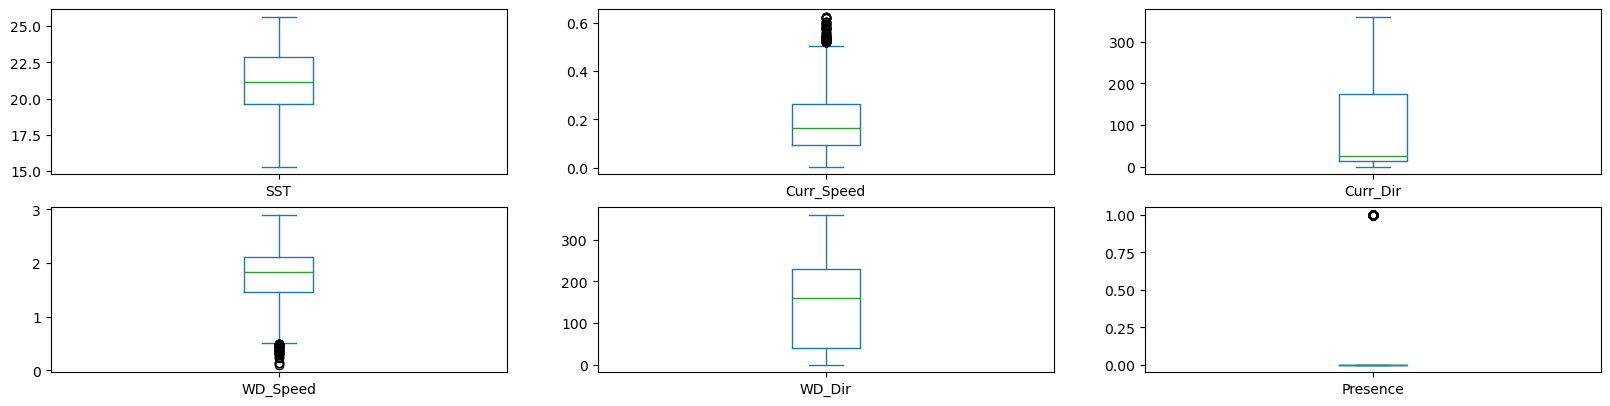

Presence
0    3284
1     225
Name: count, dtype: int64


SST               Axes(0.125,0.77;0.227941x0.11)
Curr_Speed     Axes(0.398529,0.77;0.227941x0.11)
Curr_Dir       Axes(0.672059,0.77;0.227941x0.11)
WD_Speed         Axes(0.125,0.638;0.227941x0.11)
WD_Dir        Axes(0.398529,0.638;0.227941x0.11)
Presence      Axes(0.672059,0.638;0.227941x0.11)
dtype: object

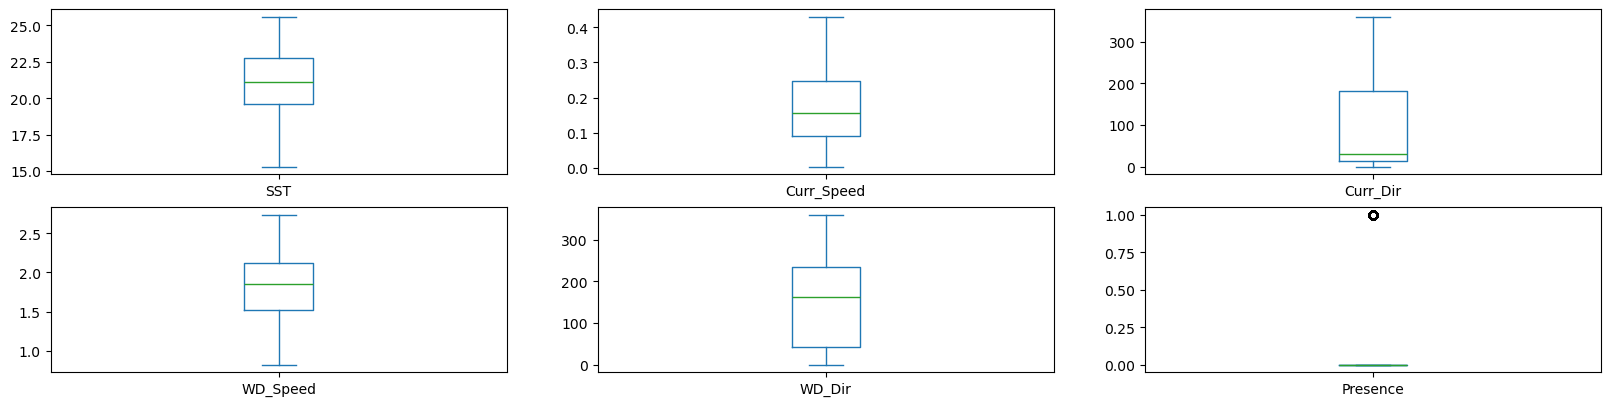

In [62]:
data.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

col_outliers = ['Curr_Speed', 'WD_Speed']
data2 = data.copy()

for col in col_outliers:
    q1, q3 = np.percentile(data2[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.0 * iqr)
    upper_bound = q3 + (1.0 * iqr)
    data2 = data2[(data2[col] >= lower_bound) & (data2[col] <= upper_bound)]

print(data2['Presence'].value_counts())

data2.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))

In [63]:
new_cat = ['Month']
new_cat = [col for col in new_cat if col in data.columns]

encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(data2[new_cat])
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(new_cat))

# Reset index before concatenation
data2.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate encoded_df and data2
final_df = pd.concat([data2.drop(columns=new_cat), encoded_df], axis=1)

In [98]:
'''X = final_df.drop(columns=['Presence'])
y = final_df['Presence']
scaler = StandardScaler()
continuous_vars = ['SST', 'Curr_Speed', 'WD_Speed', 'WD_Dir', 'Curr_Dir']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
'''
'''model = DecisionTreeClassifier()

# Apply RFE on the training data
selector = RFE(model, n_features_to_select=7)  # Choose the number of features to select
selector.fit(X_train, y_train)
print(selector.support_)
# Transform both train and test sets using the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.support_]'''

'''selected_features = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Month_Mar', 'Month_Feb']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]'''''''''

"selected_features = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Month_Mar', 'Month_Feb']\nX_train_selected = X_train[selected_features]\nX_test_selected = X_test[selected_features]"

In [110]:
model_metrics_dict = {}

# Define all models
all_models = {
    'lr': LogisticRegression(multi_class='multinomial'),
    'mlp': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver='sgd', max_iter=1000, random_state=1),
    'rf': RandomForestClassifier(),
    'dt': DecisionTreeClassifier(),
    'xgb': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, 
                             scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss'),
    'ada': AdaBoostClassifier()
}

# Loop through models
for model_name, model in all_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict and compute metrics
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store metrics in dictionary
    model_metrics_dict[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Conf_Matrix': confusion_matrix(y_test, y_pred),
        'Classification_Report': classification_report(y_test, y_pred)
    }

# Display all model metrics
for model_name, metrics in model_metrics_dict.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Conf_Matrix'])
    print("Classification Report:")
    print(metrics['Classification_Report'])
    print("-" * 60)

for model_name in ['rf', 'xgb']:  # Only models with feature importances
    model = all_models[model_name]
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, feature_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {model_name.upper()}')
        plt.show()
        print(f"{model_name.upper()} Feature Importances:")
        print(feature_importances)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

MODELLING WITH DATA ARGUMENTATION(SMOTE)

In [67]:
data = pd.read_csv('Randwick_council.csv', parse_dates=['Date'])
data['Month'] = data['Date'].dt.strftime('%b')
data = data[['Month', 'SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Presence']]

# Columns to transform
skew_data = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir']
deskew_data = ['Curr_Speed','Curr_Dir', 'WD_Speed']

# Print skewness before transformation
print("Skewness before log transformation:")
print(data[skew_data].skew())

# Apply Box-Cox transformation
transformed_data = data[deskew_data].copy()
for col in deskew_data:
    # Adding a small constant to avoid zero values
    log_transformed = transformed_data.apply(np.log1p)
log_skew = log_transformed.apply(skew)

# Replace the original columns with the transformed columns
data[deskew_data] = log_transformed

# Print skewness after transformation
print("Skewness after log transformation:")
print(data[skew_data].skew())


Skewness before log transformation:
SST          -0.052349
Curr_Speed    1.158195
Curr_Dir      1.174907
WD_Speed      0.617515
WD_Dir        0.243059
dtype: float64
Skewness after log transformation:
SST          -0.052349
Curr_Speed    0.839981
Curr_Dir      0.086919
WD_Speed     -0.544086
WD_Dir        0.243059
dtype: float64


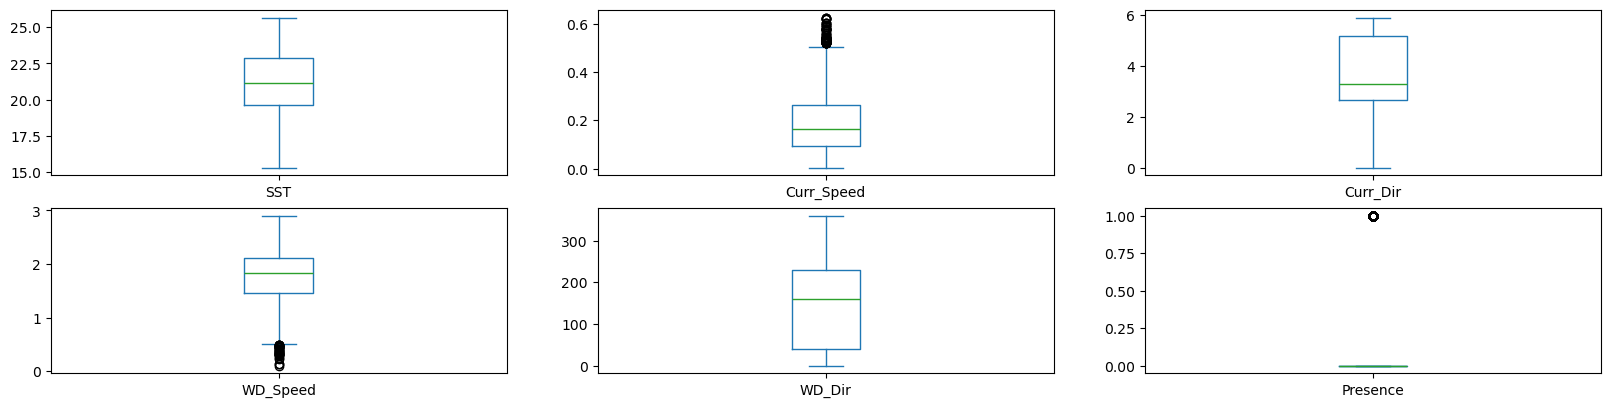

Presence
0    3284
1     225
Name: count, dtype: int64


SST               Axes(0.125,0.77;0.227941x0.11)
Curr_Speed     Axes(0.398529,0.77;0.227941x0.11)
Curr_Dir       Axes(0.672059,0.77;0.227941x0.11)
WD_Speed         Axes(0.125,0.638;0.227941x0.11)
WD_Dir        Axes(0.398529,0.638;0.227941x0.11)
Presence      Axes(0.672059,0.638;0.227941x0.11)
dtype: object

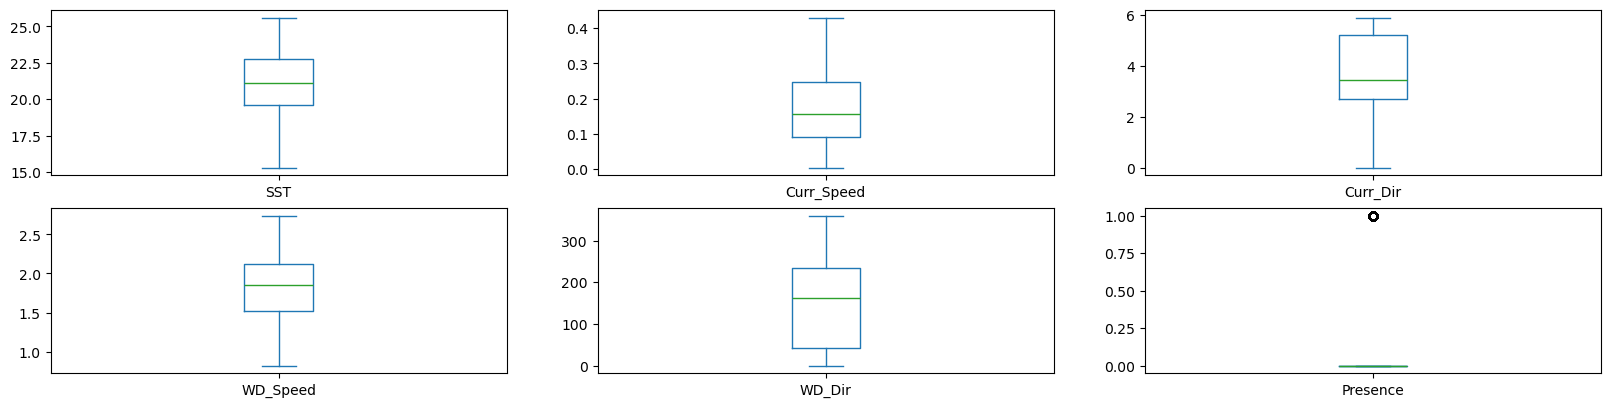

In [68]:
data.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

col_outliers = ['Curr_Speed', 'WD_Speed']
data2 = data.copy()

for col in col_outliers:
    q1, q3 = np.percentile(data2[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.0 * iqr)
    upper_bound = q3 + (1.0 * iqr)
    data2 = data2[(data2[col] >= lower_bound) & (data2[col] <= upper_bound)]

print(data2['Presence'].value_counts())
continuous_vars = ['SST', 'Curr_Speed', 'WD_Speed']
circular_vars = ['Curr_Dir', 'WD_Dir']
data2.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))

In [69]:
new_cat = ['Month']
new_cat = [col for col in new_cat if col in data2.columns]

encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(data2[new_cat])
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(new_cat))

# Reset index before concatenation
data2.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate encoded_df and data2
final_df = pd.concat([data2.drop(columns=new_cat), encoded_df], axis=1)

In [103]:
X = final_df.drop(columns=['Presence'])
y = final_df['Presence']
scaler = MinMaxScaler()
#X[continuous_vars] = scaler.fit_transform(X[continuous_vars])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
'''model = DecisionTreeClassifier()

# Apply RFE on the training data
selector = RFE(model, n_features_to_select=7)  # Choose the number of features to select
selector.fit(X_train, y_train)

# Transform both train and test sets using the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.support_]
'''
'''selected_features = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Month_Mar', 'Month_Feb']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]'''

"selected_features = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Month_Mar', 'Month_Feb']\nX_train_selected = X_train[selected_features]\nX_test_selected = X_test[selected_features]"

Class
0        458
1        241
Name: count, dtype: int64


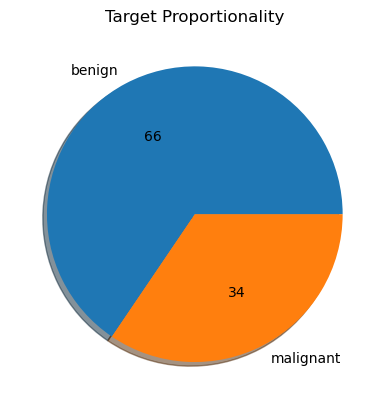

In [113]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets 
y = y.replace({2: 0, 4: 1})
print(y.value_counts())
plt.pie(y.value_counts(), labels = ['benign', 'malignant'], autopct='%.f', shadow=True)
plt.title('Target Proportionality')
plt.show()
X = X.fillna(X.Bare_nuclei.median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
#discrete_vars = ['Month_Jan', 'Month_Feb']
#smotenc = SMOTENC(categorical_features=discrete_vars, sampling_strategy='minority', random_state=42)
smotenc = SMOTE(sampling_strategy="minority", random_state= 42)
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)
steps = [('over', smotenc), ('under', under)]
# Create a pipeline
pipeline = Pipeline(steps=steps)
#smotenc = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
# Apply SMOTE and Random Under-sampling
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)
print(y_train_smote.value_counts())

Class
0        363
1        363
Name: count, dtype: int64


c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\si

Model: lr
Mean Accuracy: 0.9714, Std: 0.0000
Mean F1 Score: 0.9545, Std: 0.0000
Mean AUC: 0.9967, Std: 0.0000
------------------------------------------------------------
Model: mlp
Mean Accuracy: 0.9643, Std: 0.0000
Mean F1 Score: 0.9438, Std: 0.0000
Mean AUC: 0.9927, Std: 0.0000
------------------------------------------------------------
Model: rf
Mean Accuracy: 0.9721, Std: 0.0050
Mean F1 Score: 0.9567, Std: 0.0081
Mean AUC: 0.9947, Std: 0.0011
------------------------------------------------------------
Model: dt
Mean Accuracy: 0.9050, Std: 0.0079
Mean F1 Score: 0.8428, Std: 0.0148
Mean AUC: 0.8756, Std: 0.0122
------------------------------------------------------------
Model: xgb
Mean Accuracy: 0.9786, Std: 0.0000
Mean F1 Score: 0.9670, Std: 0.0000
Mean AUC: 0.9963, Std: 0.0000
------------------------------------------------------------
Model: ada
Mean Accuracy: 0.9643, Std: 0.0000
Mean F1 Score: 0.9438, Std: 0.0000
Mean AUC: 0.9972, Std: 0.0000
--------------------------------

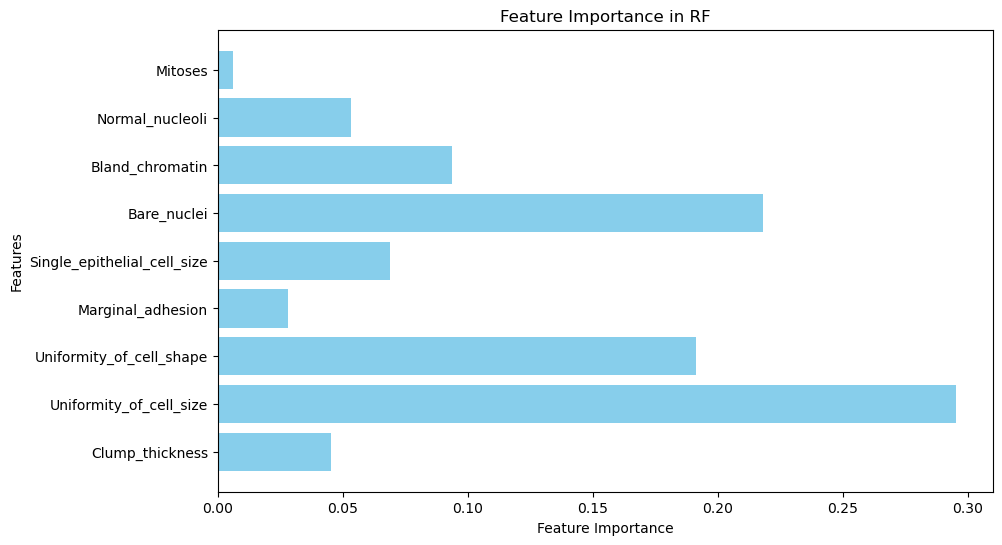

RF Feature Importances:
[0.04534571 0.29527315 0.19125469 0.02789962 0.06874739 0.21819101
 0.09384058 0.05330321 0.00614465]


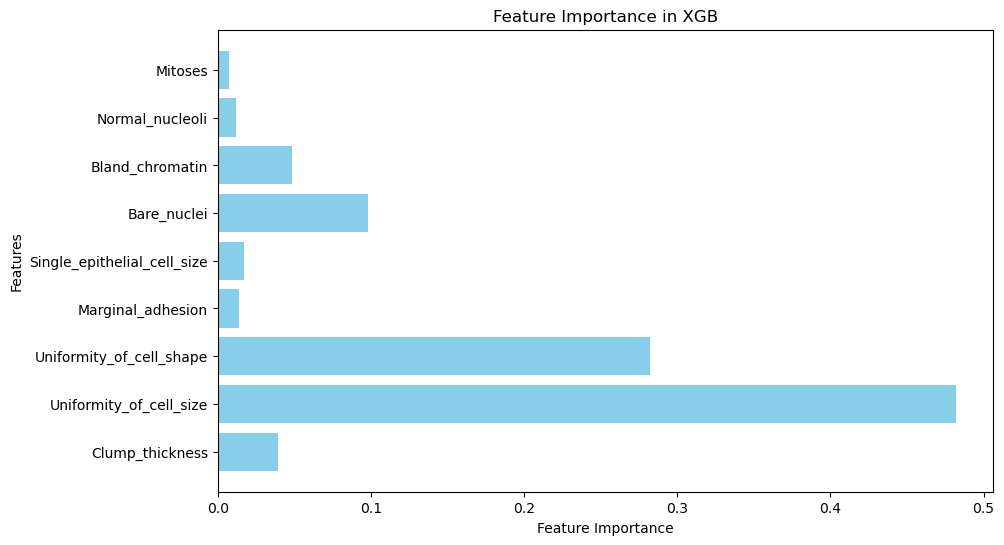

XGB Feature Importances:
[0.0393213  0.48200664 0.28205076 0.01351378 0.01699748 0.09818647
 0.04847537 0.01189465 0.00755349]


In [118]:
n_runs = 10
aggregate_metrics = {model: {'Accuracy': [], 'F1 Score': [], 'AUC': []} for model in ['lr', 'mlp', 'rf', 'dt', 'xgb', 'ada']}

for run in range(n_runs):
    model_metrics_dict = {}

    # Define all models
    all_models = {
        'lr': LogisticRegression(),
        'mlp': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver='sgd', max_iter=1000, random_state=1),
        'rf': RandomForestClassifier(),
        'dt': DecisionTreeClassifier(),
        'xgb': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, 
                                 scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss'),
        'ada': AdaBoostClassifier()
    }

    # Loop through models
    for model_name, model in all_models.items():
        # Fit the model
        model.fit(X_train_smote, y_train_smote)
        
        # Predict and compute metrics
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Store metrics in dictionary
        model_metrics_dict[model_name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_prob),
            'Conf_Matrix': confusion_matrix(y_test, y_pred),
            'Classification_Report': classification_report(y_test, y_pred)
        }

        # Aggregate metrics for calculating mean and std later
        aggregate_metrics[model_name]['Accuracy'].append(model_metrics_dict[model_name]['Accuracy'])
        aggregate_metrics[model_name]['F1 Score'].append(model_metrics_dict[model_name]['F1 Score'])
        aggregate_metrics[model_name]['AUC'].append(model_metrics_dict[model_name]['AUC'])

# Display aggregated metrics
for model_name, metrics in aggregate_metrics.items():
    mean_accuracy = np.mean(metrics['Accuracy'])
    std_accuracy = np.std(metrics['Accuracy'])
    mean_f1 = np.mean(metrics['F1 Score'])
    
    std_f1 = np.std(metrics['F1 Score'])
    mean_auc = np.mean(metrics['AUC'])
    std_auc = np.std(metrics['AUC'])

    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}, Std: {std_accuracy:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}, Std: {std_f1:.4f}")
    print(f"Mean AUC: {mean_auc:.4f}, Std: {std_auc:.4f}")
    print("-" * 60)

for model_name, metrics in model_metrics_dict.items():
        if run == 9:  # Print the class report only in the last run
            print("Confusion Matrix:")
            print(metrics['Conf_Matrix'])
            print("Classification Report:")
            print(classification_report(y_test, y_pred))  # Use this to print the report
            print("-" * 60)


# Plot feature importances for models that support it
for model_name in ['rf', 'xgb']:  # Only models with feature importances
    model = all_models[model_name]
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, feature_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {model_name.upper()}')
        plt.show()
        print(f"{model_name.upper()} Feature Importances:")
        print(feature_importances)

c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\ensem

Model: lr
Accuracy: 0.6282
F1 Score: 0.2067
AUC: 0.6975
Confusion Matrix:
[[407 245]
 [ 16  34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.62      0.76       652
           1       0.12      0.68      0.21        50

    accuracy                           0.63       702
   macro avg       0.54      0.65      0.48       702
weighted avg       0.90      0.63      0.72       702

------------------------------------------------------------
Model: mlp
Accuracy: 0.3504
F1 Score: 0.1648
AUC: 0.6879
Confusion Matrix:
[[201 451]
 [  5  45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.31      0.47       652
           1       0.09      0.90      0.16        50

    accuracy                           0.35       702
   macro avg       0.53      0.60      0.32       702
weighted avg       0.91      0.35      0.45       702

--------------------------------------------

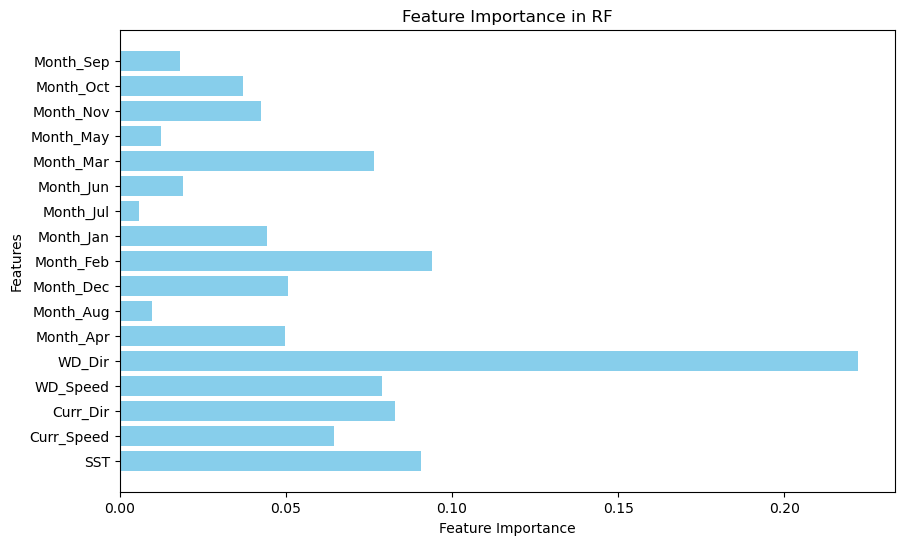

RF Feature Importances:
[0.09075551 0.06443932 0.08271677 0.07902797 0.22199314 0.04982035
 0.00989333 0.05080733 0.0941266  0.04431365 0.00589668 0.01915741
 0.07650548 0.01250736 0.04264511 0.03718162 0.01821238]


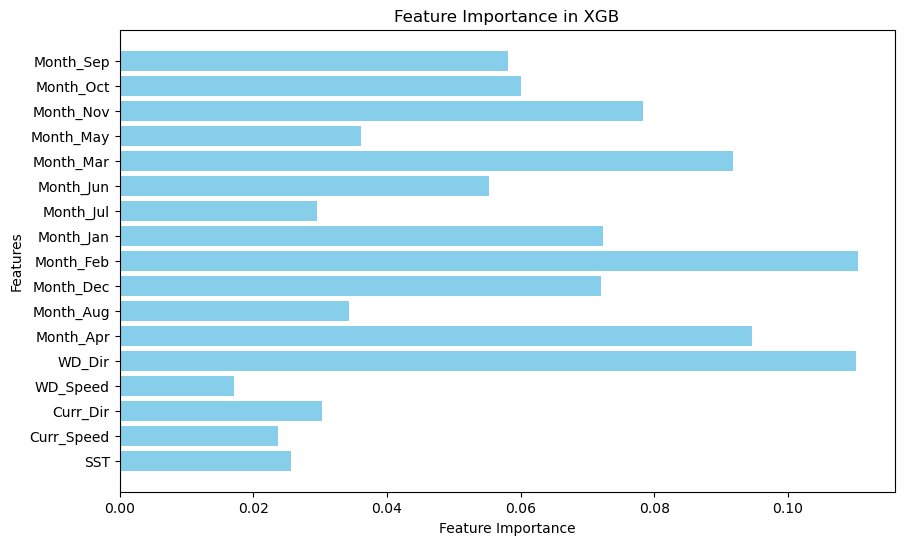

XGB Feature Importances:
[0.02568721 0.02373551 0.030337   0.0170987  0.11017916 0.09460875
 0.03440407 0.07199892 0.11043399 0.07233481 0.02949509 0.05529872
 0.09176847 0.03608475 0.07834425 0.06014089 0.0580498 ]


In [72]:
model_metrics_dict = {}

# Define all models
all_models = {
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver='sgd', max_iter=1000, random_state=1),
    'rf': RandomForestClassifier(),
    'dt': DecisionTreeClassifier(),
    'xgb': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, 
                             scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss'),
    'ada': AdaBoostClassifier()
}

# Loop through models
for model_name, model in all_models.items():
    # Fit the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict and compute metrics
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store metrics in dictionary
    model_metrics_dict[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Conf_Matrix': confusion_matrix(y_test, y_pred),
        'Classification_Report': classification_report(y_test, y_pred)
    }

# Display all model metrics
for model_name, metrics in model_metrics_dict.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Conf_Matrix'])
    print("Classification Report:")
    print(metrics['Classification_Report'])
    print("-" * 60)

for model_name in ['rf', 'xgb']:  # Only models with feature importances
    model = all_models[model_name]
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, feature_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {model_name.upper()}')
        plt.show()
        print(f"{model_name.upper()} Feature Importances:")
        print(feature_importances)

In [195]:
'''data = pd.read_csv('Randwick_council.csv', parse_dates=['Date'])
data['Month'] = data['Date'].dt.strftime('%b')
data = data[['Month', 'Beach', 'Beach_Key', 'Surf_Club', 'Lat', 'Lon', 'Orient', 'Embayment', 'SST',
             'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Presence']]

skew_data = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir']
deskew_data = ['Curr_Speed', 'WD_Speed']

# Print skewness before transformation
print("Skewness before log transformation:")
print(data[skew_data].skew())

# Apply Box-Cox transformation
transformed_data = data[deskew_data].copy()
for col in deskew_data:
    # Adding a small constant to avoid zero values
    log_transformed = transformed_data.apply(np.log1p)
log_skew = log_transformed.apply(skew)

# Replace the original columns with the transformed columns
data[deskew_data] = log_transformed

# Print skewness after transformation
print("Skewness after log transformation:")
print(data[skew_data].skew())'''


'data = pd.read_csv(\'Randwick_council.csv\', parse_dates=[\'Date\'])\ndata[\'Month\'] = data[\'Date\'].dt.strftime(\'%b\')\ndata = data[[\'Month\', \'Beach\', \'Beach_Key\', \'Surf_Club\', \'Lat\', \'Lon\', \'Orient\', \'Embayment\', \'SST\',\n             \'Curr_Speed\', \'Curr_Dir\', \'WD_Speed\', \'WD_Dir\', \'Presence\']]\n\nskew_data = [\'SST\', \'Curr_Speed\', \'Curr_Dir\', \'WD_Speed\', \'WD_Dir\']\ndeskew_data = [\'Curr_Speed\', \'WD_Speed\']\n\n# Print skewness before transformation\nprint("Skewness before log transformation:")\nprint(data[skew_data].skew())\n\n# Apply Box-Cox transformation\ntransformed_data = data[deskew_data].copy()\nfor col in deskew_data:\n    # Adding a small constant to avoid zero values\n    log_transformed = transformed_data.apply(np.log1p)\nlog_skew = log_transformed.apply(skew)\n\n# Replace the original columns with the transformed columns\ndata[deskew_data] = log_transformed\n\n# Print skewness after transformation\nprint("Skewness after log trans

In [196]:
'''
data.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

col_outliers = ['Curr_Speed', 'WD_Speed']
data2 = data.copy()

for col in col_outliers:
    q1, q3 = np.percentile(data2[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.0 * iqr)
    upper_bound = q3 + (1.0 * iqr)
    data2 = data2[(data2[col] >= lower_bound) & (data2[col] <= upper_bound)]

print(data2['Presence'].value_counts())

data2.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))'''

"\ndata.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))\nplt.show()\n\ncol_outliers = ['Curr_Speed', 'WD_Speed']\ndata2 = data.copy()\n\nfor col in col_outliers:\n    q1, q3 = np.percentile(data2[col], [25, 75])\n    iqr = q3 - q1\n    lower_bound = q1 - (1.0 * iqr)\n    upper_bound = q3 + (1.0 * iqr)\n    data2 = data2[(data2[col] >= lower_bound) & (data2[col] <= upper_bound)]\n\nprint(data2['Presence'].value_counts())\n\ndata2.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))"

In [185]:
'''
new_cat = ['Month', 'Beach', 'Beach_Key', 'Surf_Club', 'Lat', 'Lon', 'Orient', 'Embayment']
new_cat = [col for col in new_cat if col in data.columns]

encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(data2[new_cat])
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(new_cat))

# Reset index before concatenation
data2.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate encoded_df and data2
final_df = pd.concat([data2.drop(columns=new_cat), encoded_df], axis=1)'''


"\nnew_cat = ['Month', 'Beach', 'Beach_Key', 'Surf_Club', 'Lat', 'Lon', 'Orient', 'Embayment']\nnew_cat = [col for col in new_cat if col in data.columns]\n\nencoder = OneHotEncoder()\nencoded_df = encoder.fit_transform(data2[new_cat])\nencoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(new_cat))\n\n# Reset index before concatenation\ndata2.reset_index(drop=True, inplace=True)\nencoded_df.reset_index(drop=True, inplace=True)\n\n# Concatenate encoded_df and data2\nfinal_df = pd.concat([data2.drop(columns=new_cat), encoded_df], axis=1)"

In [186]:
'''X = final_df.drop(columns=['Presence'])
y = final_df['Presence']
scaler = StandardScaler()
continuous_vars = ['SST', 'Curr_Speed', 'WD_Speed', 'WD_Dir', 'Curr_Dir']

X[continuous_vars] = scaler.fit_transform(X[continuous_vars])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier()

# Apply RFE on the training data
selector = RFE(model, n_features_to_select=20)  # Choose the number of features to select
selector.fit(X_train, y_train)
print(selector.support_)
# Transform both train and test sets using the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.support_]'''

"X = final_df.drop(columns=['Presence'])\ny = final_df['Presence']\nscaler = StandardScaler()\ncontinuous_vars = ['SST', 'Curr_Speed', 'WD_Speed', 'WD_Dir', 'Curr_Dir']\n\nX[continuous_vars] = scaler.fit_transform(X[continuous_vars])\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nmodel = DecisionTreeClassifier()\n\n# Apply RFE on the training data\nselector = RFE(model, n_features_to_select=20)  # Choose the number of features to select\nselector.fit(X_train, y_train)\nprint(selector.support_)\n# Transform both train and test sets using the selected features\nX_train_selected = selector.transform(X_train)\nX_test_selected = selector.transform(X_test)\nselected_features = X_train.columns[selector.support_]"

In [187]:
'''smotenc = SMOTE(sampling_strategy="minority", random_state= 42)
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)
steps = [('over', smotenc), ('under', under)]
# Create a pipeline
pipeline = Pipeline(steps=steps)
#smotenc = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
# Apply SMOTE and Random Under-sampling
X_train_smote, y_train_smote = pipeline.fit_resample(X_train_selected, y_train)'''

'smotenc = SMOTE(sampling_strategy="minority", random_state= 42)\nunder = RandomUnderSampler(sampling_strategy=\'majority\', random_state=42)\nsteps = [(\'over\', smotenc), (\'under\', under)]\n# Create a pipeline\npipeline = Pipeline(steps=steps)\n#smotenc = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy=\'all\'))\n# Apply SMOTE and Random Under-sampling\nX_train_smote, y_train_smote = pipeline.fit_resample(X_train_selected, y_train)'

In [188]:
'''model_metrics_dict = {}

# Define all models
all_models = {
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver='sgd', max_iter=1000, random_state=1),
    'rf': RandomForestClassifier(),
    'dt': DecisionTreeClassifier(),
    'xgb': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, 
                             scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss'),
    'ada': AdaBoostClassifier()
}

# Loop through models
for model_name, model in all_models.items():
    # Fit the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict and compute metrics
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]
    
    # Store metrics in dictionary
    model_metrics_dict[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Conf_Matrix': confusion_matrix(y_test, y_pred),
        'Classification_Report': classification_report(y_test, y_pred)
    }

# Display all model metrics
for model_name, metrics in model_metrics_dict.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Conf_Matrix'])
    print("Classification Report:")
    print(metrics['Classification_Report'])
    print("-" * 60)

for model_name in ['rf', 'xgb']:  # Only models with feature importances
    model = all_models[model_name]
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, feature_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {model_name.upper()}')
        plt.show()
        print(f"{model_name.upper()} Feature Importances:")
        print(feature_importances)'''

'model_metrics_dict = {}\n\n# Define all models\nall_models = {\n    \'lr\': LogisticRegression(),\n    \'mlp\': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver=\'sgd\', max_iter=1000, random_state=1),\n    \'rf\': RandomForestClassifier(),\n    \'dt\': DecisionTreeClassifier(),\n    \'xgb\': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, \n                             scale_pos_weight=3, use_label_encoder=False, eval_metric=\'logloss\'),\n    \'ada\': AdaBoostClassifier()\n}\n\n# Loop through models\nfor model_name, model in all_models.items():\n    # Fit the model\n    model.fit(X_train_smote, y_train_smote)\n    \n    # Predict and compute metrics\n    y_pred = model.predict(X_test_selected)\n    y_prob = model.predict_proba(X_test_selected)[:, 1]\n    \n    # Store metrics in dictionary\n    model_metrics_dict[model_name] = {\n        \'Accuracy\': accuracy_score(y_test, y_pred),\n        \'F1 Score\': f1_score(y_test, y_pred),\n       

STEREOGRAPHIC PROJECTION MODELLING

In [8]:
data = pd.read_csv('Randwick_council.csv', parse_dates=['Date'])
data['Month'] = data['Date'].dt.strftime('%b')
data = data[['Month', 'SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir', 'Presence']]
skew_data = ['SST', 'Curr_Speed',  'WD_Speed']
deskew_data = ['Curr_Speed', 'WD_Speed']

# Print skewness before transformation
print("Skewness before log transformation:")
print(data[skew_data].skew())

for col in deskew_data:
    # Adding a small constant to avoid zero values
    data[col] = np.log1p(data[col])

# Print skewness after transformation
print("Skewness after log transformation:")
print(data[skew_data].skew())

Skewness before log transformation:
SST          -0.052349
Curr_Speed    1.158195
WD_Speed      0.617515
dtype: float64
Skewness after log transformation:
SST          -0.052349
Curr_Speed    0.839981
WD_Speed     -0.544086
dtype: float64


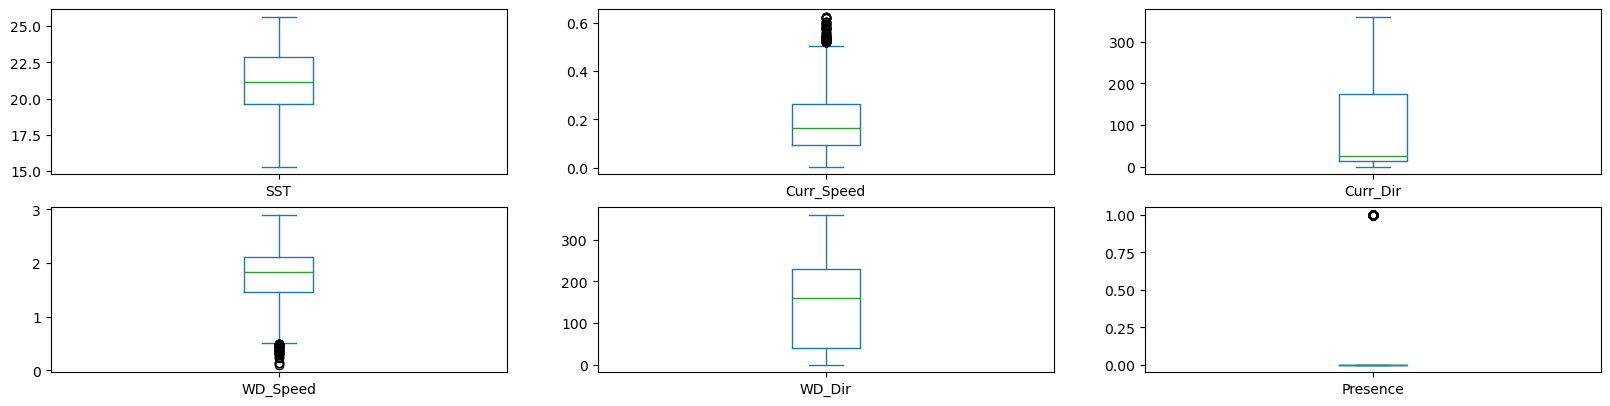

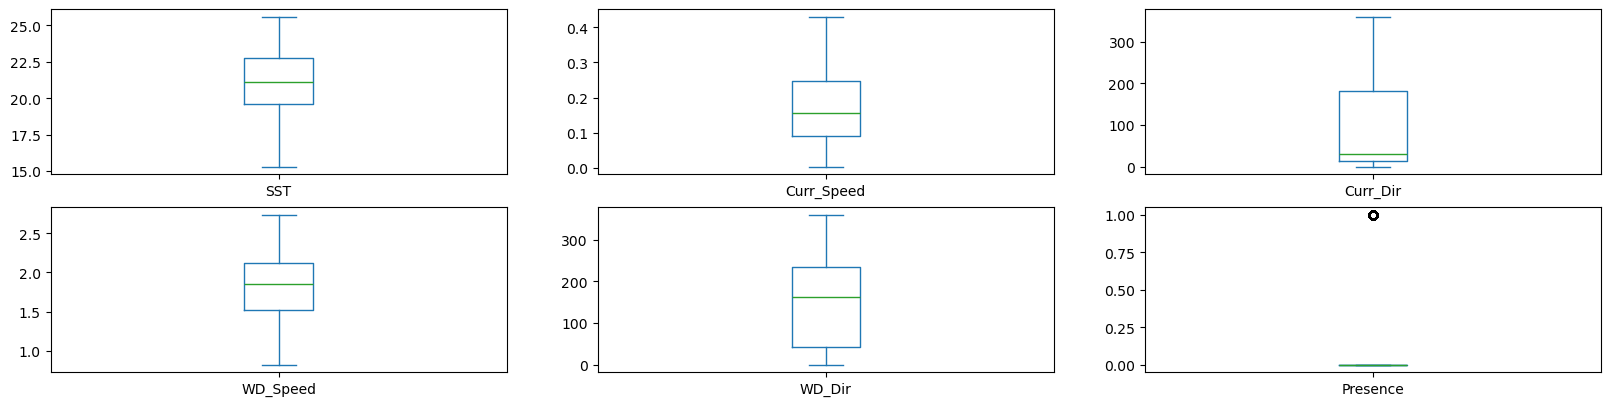

In [10]:
data.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

col_outliers = ['Curr_Speed', 'WD_Speed']
data2 = data.copy()

for col in col_outliers:
    q1, q3 = np.percentile(data2[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.0 * iqr)
    upper_bound = q3 + (1.0 * iqr)
    data2 = data2[(data2[col] >= lower_bound) & (data2[col] <= upper_bound)]
data2.plot(kind='box', subplots=True, layout=(6, 3), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

In [81]:
new_cat = ['Month']
new_cat = [col for col in new_cat if col in data2.columns]

encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(data2[new_cat])
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(new_cat))

# Reset index before concatenation
data2.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate encoded_df and data3
final_df = pd.concat([data2.drop(columns=new_cat), encoded_df], axis=1)


# Splitting the data into features and target
features = final_df.drop(columns=['Presence'])
target = final_df['Presence']
continuous_vars = ['SST', 'Curr_Speed', 'Curr_Dir', 'WD_Speed', 'WD_Dir']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

circular_vars = ['Curr_Dir', 'WD_Dir']
discrete_vars = ['Month_Apr','Month_Aug','Month_Dec','Month_Feb','Month_Jan','Month_Jul','Month_Jun',
                    'Month_Mar','Month_May','Month_Nov', 'Month_Oct','Month_Sep']
'''scaler = Normalizer()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])'''
circular_rad = np.radians(X_train[circular_vars].values)
print(X_train.head())

            SST  Curr_Speed  Curr_Dir  WD_Speed      WD_Dir  Month_Apr  \
801   17.829219    0.222284  3.378425  1.848584  157.116299        0.0   
3052  24.016083    0.143689  3.277230  1.675928  159.560357        0.0   
3012  22.444075    0.261858  1.982763  1.895313   41.331138        0.0   
2522  19.307840    0.256573  3.104172  1.722370  172.269181        0.0   
231   21.510209    0.094857  5.876127  1.978095   34.826199        0.0   

      Month_Aug  Month_Dec  Month_Feb  Month_Jan  Month_Jul  Month_Jun  \
801         0.0        0.0        0.0        0.0        0.0        0.0   
3052        0.0        0.0        1.0        0.0        0.0        0.0   
3012        0.0        0.0        0.0        1.0        0.0        0.0   
2522        0.0        0.0        0.0        0.0        0.0        0.0   
231         0.0        1.0        0.0        0.0        0.0        0.0   

      Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  
801         0.0        0.0        0.0        0.0

In [87]:

X_train['Curr_Dir_x'] = np.cos(circular_rad[:, 0]) / (1 - np.sin(circular_rad[:, 0]))
X_train['Curr_Dir_y'] = np.sin(circular_rad[:, 0]) / (1 - np.sin(circular_rad[:, 0]))
X_train['WD_Dir_x'] = np.cos(circular_rad[:, 1]) / (1 - np.sin(circular_rad[:, 1]))
X_train['WD_Dir_y'] = np.sin(circular_rad[:, 1]) / (1 - np.sin(circular_rad[:, 1]))

# Check columns before dropping
print("Columns before dropping:", X_train.columns)

# Drop original circular variables
X_train.drop(columns=circular_vars, inplace=True, errors='ignore')
print("Columns before dropping:", X_train.columns)
smotenc = SMOTE(sampling_strategy="minority", random_state= 42)
#smotenc = SMOTENC(categorical_features=discrete_vars, sampling_strategy='minority', random_state=42)
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)
steps = [('over', smotenc), ('under', under)]
# Create a pipeline
pipeline = Pipeline(steps=steps)

    # Apply SMOTE and Random Under-sampling
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)
# Ensure columns exist in SMOTE DataFrame
print("SMOTE Columns:", X_train_smote.columns)

# After SMOTE, convert synthetic samples back to stereographic projection
for i, var in enumerate(circular_vars):
    x_proj_smote = X_train_smote[f'{var}_x']
    y_proj_smote = X_train_smote[f'{var}_y']
    
    # Avoid division by zero
    #denominator = (1 - y_proj_smote)
    #denominator = np.where(denominator == 0, np.nan, denominator)  # Replace zero with NaN to avoid division by zero
    
    # Calculate angles in radians
    theta = np.arctan2(y_proj_smote, x_proj_smote)
    
    # Convert back to degrees
    theta_degrees = np.degrees(theta)
    
    # Ensure degrees are in the range [0, 360)
    theta_degrees = np.mod(theta_degrees, 360)
    
    # Add back-converted features to the DataFrame
    X_train_smote[f'{var}'] = theta_degrees
X_train_smote.drop(columns=[f'{var}_x' for var in circular_vars] + [f'{var}_y' for var in circular_vars], inplace=True)
print(X_train_smote.head())

Columns before dropping: Index(['SST', 'Curr_Speed', 'WD_Speed', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Curr_Dir_x',
       'Curr_Dir_y', 'WD_Dir_x', 'WD_Dir_y'],
      dtype='object')
Columns before dropping: Index(['SST', 'Curr_Speed', 'WD_Speed', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Curr_Dir_x',
       'Curr_Dir_y', 'WD_Dir_x', 'WD_Dir_y'],
      dtype='object')
SMOTE Columns: Index(['SST', 'Curr_Speed', 'WD_Speed', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Curr_Dir_x',
       'Curr_Dir_y', 'WD_Dir_x', 'WD_Dir_y'],
      dtype='object')
            SST  Curr_Speed  WD_Speed  Month_Apr  Month_Aug

Index(['SST', 'Curr_Speed', 'WD_Speed', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Curr_Dir',
       'WD_Dir'],
      dtype='object')
Index(['SST', 'Curr_Speed', 'WD_Speed', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Curr_Dir',
       'WD_Dir'],
      dtype='object')


c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\z5516899\AppData\Local\anaconda3\envs\Bluebottle_V02\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: lr
Accuracy: 0.6144
F1 Score: 0.1880
AUC: 0.7014
Confusion Matrix:
[[600 381]
 [ 25  47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.61      0.75       981
           1       0.11      0.65      0.19        72

    accuracy                           0.61      1053
   macro avg       0.53      0.63      0.47      1053
weighted avg       0.90      0.61      0.71      1053

------------------------------------------------------------
Model: mlp
Accuracy: 0.6838
F1 Score: 0.2309
AUC: 0.7336
Confusion Matrix:
[[670 311]
 [ 22  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       981
           1       0.14      0.69      0.23        72

    accuracy                           0.68      1053
   macro avg       0.55      0.69      0.52      1053
weighted avg       0.91      0.68      0.76      1053

--------------------------------------------

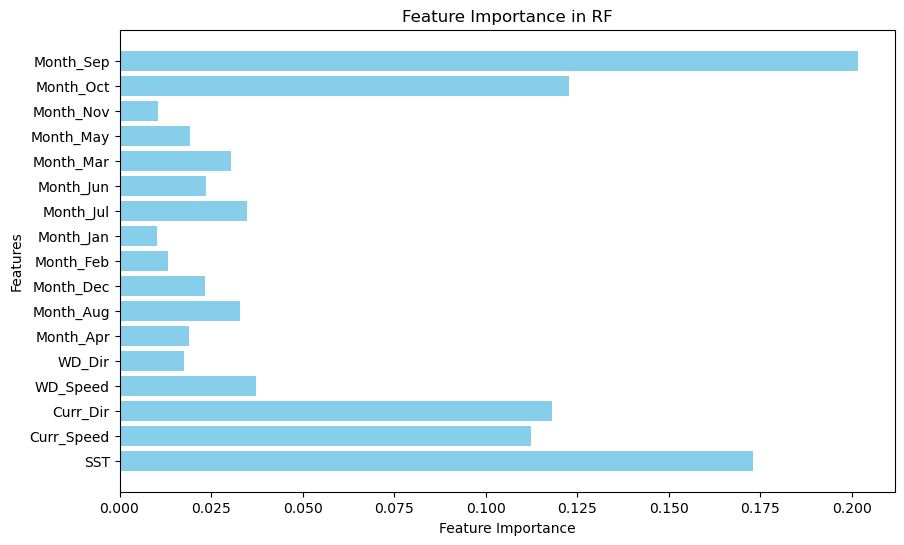

RF Feature Importances:
[0.17296955 0.11228244 0.11803316 0.03729003 0.01768523 0.01892492
 0.03297886 0.02331697 0.0131393  0.01031972 0.03471519 0.02366227
 0.03045673 0.01914261 0.01060483 0.12288139 0.2015968 ]


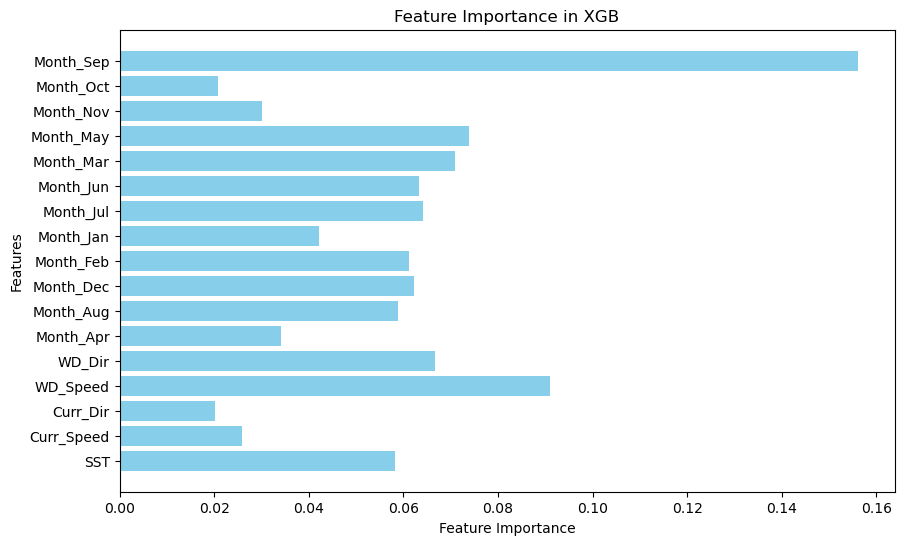

XGB Feature Importances:
[0.0582296  0.02597791 0.02028415 0.09100253 0.06672126 0.03422531
 0.05885253 0.0621508  0.0612152  0.04223587 0.06407768 0.06335101
 0.0708799  0.0737955  0.03009167 0.02087106 0.15603799]


In [95]:
scaler = StandardScaler()
X_train_smote[continuous_vars] = scaler.fit_transform(X_train_smote[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
X_test = X_test[X_train_smote.columns]
print(X_train_smote.columns)
print(X_test.columns)

model_metrics_dict = {}

# Define all models
all_models = {
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, solver='sgd', max_iter=1000, random_state=1),
    'rf': RandomForestClassifier(),
    'dt': DecisionTreeClassifier(),
    'xgb': xgb.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, 
                             scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss'),
    'ada': AdaBoostClassifier()
}

# Loop through models
for model_name, model in all_models.items():
    # Fit the model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict and compute metrics
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store metrics in dictionary
    model_metrics_dict[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Conf_Matrix': confusion_matrix(y_test, y_pred),
        'Classification_Report': classification_report(y_test, y_pred)
    }

# Display all model metrics
for model_name, metrics in model_metrics_dict.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Conf_Matrix'])
    print("Classification Report:")
    print(metrics['Classification_Report'])
    print("-" * 60)

for model_name in ['rf', 'xgb']:  # Only models with feature importances
    model = all_models[model_name]
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(features.columns, feature_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {model_name.upper()}')
        plt.show()
        print(f"{model_name.upper()} Feature Importances:")
        print(feature_importances)